# Information

*   Title: Creating a Question & Answering System
*   Natural Language Processing - final project
*   Professor: Paolo Torroni
*   University of Bologna

Developing Team:
*   Ali Tavana (ali.tavana@studio.unibo.it
*   Saeid Amirhaftehran (saeid.amirhaftehran@studio.unibo.it)



**NOTE: our final saved model (pytorch_model.bin) is available [here](https://drive.google.com/drive/folders/11Ccuvn6TFP7EPSRpKXIMozRH7Lf9mp4t?usp=sharing) to download.

# Setting Up the Environment

## Implementation of the packages

In [ ]:
import os
import torch
import collections
import json
import string
import re
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We have to install the transformers package if it's not available in our system by running code bellow:

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizerFast
import torch.nn as nn
from transformers import BertModel,BertPreTrainedModel

In [ ]:
# The path of training_set.json file that we have, for us it is uploaded
# in our google drive folder
train_path = '/content/drive/MyDrive/Colab Notebooks/NLP/training_set.json'
f = open(train_path,'r')
data = json.load(f)
f.close()

# Reading the data

In [ ]:
# extract context, question, answer from original json file
def read_data(train=True):

    num_article = len(data['data'])
    if train:
        # 90% in train
        temp_data = data['data'][:(9*num_article//10)]
    else:
        temp_data = data['data'][(9*num_article//10):]
    
    contexts = []
    questions = []
    answers = []
    
    for article in temp_data:
        for p in article['paragraphs']:
            context = p['context']
            for qa in p['qas']:
                question = qa['question']

                contexts.append(context)
                questions.append(question)
                answers.append(qa['answers'][0])
    
    return contexts, questions, answers


# get the end char index for answers in the context
def add_end_idx(answers, contexts):

    for answer, context in zip(answers, contexts):

        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two, so we need
        # fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

For Tokenizing our data set we Use BertTokenizerFast method of transformers Library. For these purposes we use BERT base model (Uncased). This model is uncased: it does not make a difference between english and English.

In [ ]:
# Instantiating a configuration with the defaults will yield a similar configuration
# bert-base-uncased architecture 
# pytorch model from a pre-trained model configuration
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
train_contexts, train_questions, train_answers = read_data()
add_end_idx(train_answers, train_contexts)

In [ ]:
# get validation data (10% of the original data)
val_contexts, val_questions, val_answers = read_data(train=False)

# Data Analysing

In [ ]:
# This method is just for plotting, nothing more
def preprocess(contexts,questions,answers,train=True):
    context_list = []
    question_list = []

    start_position = []
    end_position = []

    for i in tqdm(range(len(contexts))):
        encoding = tokenizer(contexts[i])
        token_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)
        # "[UNK]", The unknown token. A token that is not in the vocabulary cannot
        # be converted to an ID and is set to be this token instead
        context_list.append(['[UNK]']+token_list)
        
        if train:
            start = encoding.char_to_token(answers[i]['answer_start'])
            end = encoding.char_to_token(answers[i]['answer_end']-1)

            start_position.append(start)
            end_position.append(end)
    
    for i in tqdm(range(len(questions))):
        encoding = tokenizer(questions[i])
        token_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)

        question_list.append(token_list)

    if train:
        return context_list,question_list,start_position,end_position
    else:
        return context_list,question_list

In [ ]:
train_context_list,train_question_list,train_start_position,train_end_position = preprocess(train_contexts,train_questions,train_answers)

In [ ]:
val_context_list,val_question_list = preprocess(val_contexts,val_questions,val_answers,train=False)

In this part, we want to explore our dataset to see the detailes for the next steps.

In [ ]:
# a method for summarising and describing the lists
def summary_of_data(lst, name):
  average = sum(lst) / len(lst)
  minimum = min(lst)
  maxaimum = max(lst)
  print('Average of ' + name + ' is: '+ str(average))
  print('Minimum of ' + name + ' is: '+ str(minimum))
  print('Maximum of ' + name + ' is: '+ str(maxaimum))

## Context

Average of context list is: 155.99515445955055
Minimum of context list is: 26
Maximum of context list is: 854


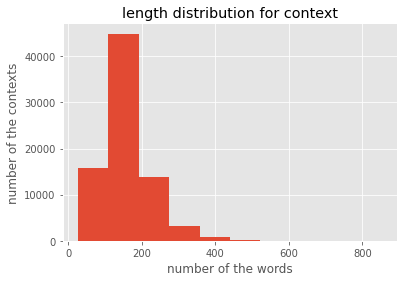

In [ ]:
# here we do our data exploration on training set
# the first thing we are interested in is the length of context
length_list = []
for i in train_context_list:
    length_list.append(len(i))
summary_of_data(length_list, 'context list')
plt.cla()
plt.hist(length_list)
plt.title('length distribution for context')
plt.ylabel("number of the contexts")
plt.xlabel("number of the words")
plt.show()

## Question 

Average of question list is: 12.317669053402689
Minimum of question list is: 1
Maximum of question list is: 61


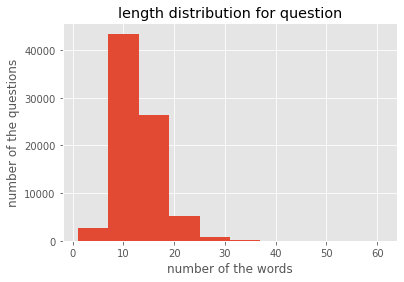

In [ ]:
length_list = []
for i in train_question_list:
    length_list.append(len(i))
summary_of_data(length_list, 'question list')
plt.cla()
plt.hist(length_list)
plt.title('length distribution for question')
plt.ylabel("number of the questions")
plt.xlabel("number of the words")
plt.show()

## Question + Context

Average of question + context list is: 168.31282351295323
Minimum of question + context list is: 34
Maximum of question + context list is: 868


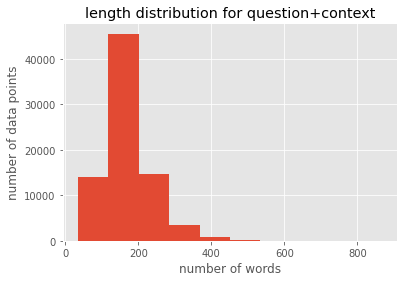

In [ ]:
length_list = []
for i in range(len(train_question_list)):
    length_list.append(len(train_question_list[i])+len(train_context_list[i]))
summary_of_data(length_list, 'question + context list')
plt.cla()
plt.hist(length_list)
plt.title('length distribution for question+context')
plt.ylabel("number of data points")
plt.xlabel("number of words")
plt.show()

## Answer

Average of answers list is: 20.227829426801815
Minimum of answers list is: 1
Maximum of answers list is: 239


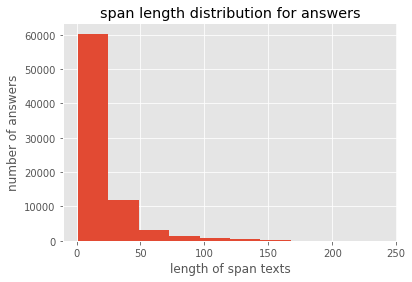

In [ ]:
# the third thing we are interested in is the distribution of span length of answers
# this is important because it can serve as a threshold for determine answerability
length_list = []
for i in train_answers:
    start = i['answer_start']
    end = i['answer_end']
    if start==0 and end==0:
        continue
    else:        
        length_list.append(end-start)
summary_of_data(length_list, 'answers list')
plt.cla()
plt.hist(length_list)
plt.title('span length distribution for answers')
plt.ylabel("number of answers")
plt.xlabel("length of span texts")
plt.show()

# Evaluation methods
The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.


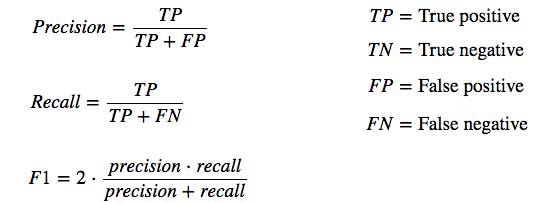


These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

In [ ]:
def compute_exact(a_gold, a_pred):
    # to define the exact match metrics
    if normalize_answer(a_gold) == normalize_answer(a_pred):
        return 1
    else:
        return 0


def compute_f1(a_gold, a_pred):
    # to define F1 score
    gold_tokens = get_tokens(a_gold)
    pred_tokens = get_tokens(a_pred)

    common = collections.Counter(gold_tokens) & collections.Counter(pred_tokens)
    num_same = sum(common.values())
    # if one of ground-truth and prediction is un-answered,
    # then F1 would be 1 if they are the same, otherwise be 0.
    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        if gold_tokens == pred_tokens:
            return 1
        else:
            return 0
    
    # if both are answered, just calculate F1 using the formula given above
    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(gold_tokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    return f1

# Data normalisation and preprocessing

In [ ]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

# BERT base

We used language representation model called BERT which stands for Bidirectional Encoder Representations from Transformers. BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

## Train Encoding

In [ ]:
# we need some additional different data preprocessing for bert finetuning
max_length = 384

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, 
                            padding='max_length', max_length=max_length)
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        if answers[i]['answer_start']==0 and answers[i]['answer_end']==0
            start_positions.append(0)
            end_positions.append(0)
        else:     
            start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
            end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
            # if None, the answer passage has been truncated
            if start_positions[-1] is None:
                start_positions[-1] = max_length-1
            if end_positions[-1] is None:
                end_positions[-1] = max_length-1
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)

## Squad Datasets (training and validation)
We define two classes named SquadDataset and SquadDataset_Validation for reading our data from our encoded train set and validation set. For this purposes we use torch.utils.data.Dataset library as super classes and defining its __getitem__ method and __len__ method. There is little different between these two classes that related to validation dataset. In validation data set we add real answer corresponding to its context as ‘gold_text’ into it.

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


class SquadDataset_Validation(torch.utils.data.Dataset):
    
    def __init__(self, encodings, answers):
        self.encodings = encodings
        self.answers = answers

    def __getitem__(self, idx):
        return_dict = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return_dict['gold_text'] = self.answers[idx]['text']
        
        return return_dict

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding='max_length', max_length=max_length)

val_dataset = SquadDataset_Validation(val_encodings, val_answers)

## Define Evaluate Method

In [ ]:
def evaluate(model, dataset):
    # disable gradient calculation
    with torch.no_grad():
        model.eval()
        device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        em = 0.0
        f1 = 0.0

        for i in tqdm(range(len(dataset))):
            temp_data = dataset[i]
            input_ids = temp_data['input_ids'].to(device).unsqueeze(0)
            attention_mask = temp_data['attention_mask'].to(device).unsqueeze(0)
            token_type_ids = temp_data['token_type_ids'].to(device).unsqueeze(0)
            start_score, end_score = model.get_scores(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            
            start_score = start_score.squeeze(0).cpu()
            end_score = end_score.squeeze(0).cpu()

            answer_start = torch.argmax(start_score).item()
            answer_end = torch.argmax(end_score).item()

            pred = ''
            length = start_score.size(0)
            
            if answer_start == 0 or answer_end == 0 or answer_start==(length-1) or answer_end==(length-1):
                pred = ''
            
            elif answer_end < answer_start:
                pred = ''
            
            elif answer_end - answer_start > 20:
                pred = ''
            
            else:
                input_ids.cpu()
                pred = tokenizer.decode(input_ids[0][answer_start:(answer_end+1)])
            
            gold_text = dataset[i]['gold_text']

            em += compute_exact(gold_text,pred)
            f1 += compute_f1(gold_text,pred)
        
        em /= len(dataset)
        f1 /= len(dataset)

        print('EM: %.5f'%em)
        print('F1: %.5f'%f1)

        return em, f1

## BERT Question Answering Class


In [ ]:
class Bert_QA(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        
        self.bert = BertModel(config, add_pooling_layer=False)
        # linear transformation
        self.fc = nn.Linear(config.hidden_size, 2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        start_positions,
        end_positions,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        sequence_output = outputs.last_hidden_state #[batch,length,dim]

        # attention_mask [batch,length]
        # token_type_ids [batch,length]

        logits = self.fc(sequence_output) #[batch,length,2]
        
        context_mask = (attention_mask-token_type_ids).unsqueeze(-1) # [batch,length,1]
        logits = logits + (context_mask + 1e-45).log()

        start_logits, end_logits = logits.split(1, dim=-1) # 2*[batch,length,1]
        start_logits = start_logits.squeeze(-1) # [batch,length]
        end_logits = end_logits.squeeze(-1) #[batch,length]

        start_loss = self.criterion(start_logits, start_positions)
        end_loss = self.criterion(end_logits, end_positions)
        loss = start_loss + end_loss

        return loss
    
    
    def get_scores(self,
        input_ids,
        attention_mask,
        token_type_ids
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state

        logits = self.fc(sequence_output) #[batch,length,2]
        
        context_mask = (attention_mask-token_type_ids).unsqueeze(-1) # [batch,length,1]
        logits = logits + (context_mask + 1e-45).log()

        start_logits, end_logits = logits.split(1, dim=-1) # 2*[batch,length,1]
        start_logits = start_logits.squeeze(-1) # [batch,length]
        end_logits = end_logits.squeeze(-1) #[batch,length]

        start_score = nn.Softmax(dim=1)(start_logits)
        end_score = nn.Softmax(dim=1)(end_logits)

        return start_score, end_score

## Training The Model
We define our model from Bert_QA class. Using SquadDataset class that we define we read our train set then using DataLoader method of torch.utils.data library we shuffle our train set and set our batch size to 24.

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

torch.cuda.empty_cache()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = Bert_QA.from_pretrained('bert-base-uncased')
model.to(device)
# To train the model, we should first set it back in training mode
model.train()

train_dataset = SquadDataset(train_encodings)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, drop_last=True)
# We define our optimization as AdamW which takes it parameter from 
# pre trained uncased Bert model. The AdamW optimizer decouples the 
# weight decay from the optimization step. This means that the weight 
# decay and learning rate can be optimized separately, i.e., changing 
# the learning rate does not change the optimal weight decay. 
# and finally, we set our learning rate to 3e-5.
optim = AdamW(model.parameters(), lr=3e-5)

iter_counter = 0
best_f1 = 0
avg_loss = 0

for epoch in range(3):
    print('epoch %d start!'%(epoch+1))
    for batch in train_loader:
        # We use optim.zero_grad() to sets the gradients of all 
        # optimized torch.Tensor to zero.
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        loss = model(input_ids, attention_mask=attention_mask, start_positions=start_positions,
                     end_positions=end_positions, token_type_ids=token_type_ids)
        # computes dloss/dx for every parameter x which has requires_grad=True 
        # these are accumulated into x.grad for every parameter x.
        loss.backward()
        # is performs a parameter update based on the current gradient (stored 
        # in . grad attribute of a parameter) and the update rule.
        # backward() multiple times accumulates the gradient (by addition) 
        # for each parameter.
        optim.step()

        iter_counter += 1

        avg_loss += loss.item()

        if iter_counter%100 == 0:
            avg_loss /= 100
            print('iter %d'%iter_counter)
            print('loss %.5f'%avg_loss)
            avg_loss = 0
            print()
        if iter_counter%2000 == 0:
            em,f1 = evaluate(model,val_dataset)
            model.train()
            if f1>best_f1:
                best_f1 = f1
                model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP/v2/bert_qa_model_uncased')
                print('best model!')
            print()
    print('epoch %d finish!'%(epoch+1))

## Evaluate the final Results
after running the previous code, here use our generated model file to evaluate.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_bert = Bert_QA.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP/v2/bert_qa_model_uncased', )
model_bert.to(device)
model_bert.eval()
evaluate(model_bert, val_dataset)

EM: 0.57551
F1: 0.72475


In [ ]:
def online_predict(question, context):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        temp_encoding = tokenizer(context,question,truncation=True,padding=True)
        input_ids = torch.LongTensor(temp_encoding['input_ids']).unsqueeze(0).to(device)
        token_type_ids = torch.LongTensor(temp_encoding['token_type_ids']).unsqueeze(0).to(device)
        attention_mask = torch.LongTensor(temp_encoding['attention_mask']).unsqueeze(0).to(device)

        start_score, end_score = model_bert.get_scores(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        start_score = start_score.squeeze(0).cpu()
        end_score = end_score.squeeze(0).cpu()

        answer_start = torch.argmax(start_score).item()
        answer_end = torch.argmax(end_score).item()

        pred = ''
        length = start_score.size(0)

        if answer_start == 0 or answer_end == 0 or answer_start==(length-1) or answer_end==(length-1):
            pred = ''

        elif answer_end < answer_start:
            pred = ''

        elif answer_end - answer_start > 20:
            pred = ''

        else:
            input_ids.cpu()
            pred = tokenizer.decode(input_ids[0][answer_start:(answer_end+1)])

        return pred, True

## Results on Validation set


In [ ]:
for i in range(20):
    index = np.random.randint(len(val_contexts))
    c = val_contexts[index]
    q = val_questions[index]
    p_bert,_ = online_predict(q,c)
    print('context:')
    print(c)
    print('question:')
    print(q)
    print('gold answer: %s'%val_answers[index]['text'])
    print('bert answer: %s'%p_bert)
    print()

context:
Theologus Autodidactus, written by the Arabian polymath Ibn al-Nafis (1213–1288), is the first example of a science fiction novel. It deals with various science fiction elements such as spontaneous generation, futurology, the end of the world and doomsday, resurrection, and the afterlife. Rather than giving supernatural or mythological explanations for these events, Ibn al-Nafis attempted to explain these plot elements using the scientific knowledge of biology, astronomy, cosmology and geology known in his time. Ibn al-Nafis' fiction explained Islamic religious teachings via science and Islamic philosophy.
question:
What type of book is Theologus Autodidactus the first type of?
gold answer: science fiction
bert answer: science fiction novel

context:
Puritans were blocked from changing the established church from within, and were severely restricted in England by laws controlling the practice of religion. Their beliefs, however, were transported by the emigration of congregati

# Conclusion 
In this application, we implemented the brilliant BERT model for predicting the answers of the questions. They are a lots of alternatives for doing this task. For example:


1.   RoBERTa by Facebook
2.   ALBERT by Google
3.   DistilBERT by Hugging Face
4.   ...

BERT is undoubtedly a breakthrough in the use of Machine Learning for Natural Language Processing. The fact that it’s approachable and allows fast fine-tuning will likely allow a wide range of practical applications in the future. It's technically easy to implement, but empirically so strong.
